# Behavior Detection with Sensor Data
**Author:** Rafa R

I will process raw sensor data, engineer relevant features, train a machine learning model, and evaluate its performance.

## First Import Libraries
I import the necessary Python libraries for data processing and modeling.

In [1]:
import numpy as np  # for numerical operations
import pandas as pd  # for data handling
import os  # to manage file paths
from sklearn.model_selection import train_test_split  # to split data
from sklearn.ensemble import RandomForestClassifier  # example model
import matplotlib.pyplot as plt  # for plotting

# Ensure plots display inline in Jupyter
%matplotlib inline

## Second Load Data
I load the training and demographics CSV files, with fallback paths for different environments.

In [2]:
# Define file paths
train_path = '/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv'
demo_path = '/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv'

try:
    train_df = pd.read_csv(train_path)
    demographics_df = pd.read_csv(demo_path)
    print("Data loaded from Kaggle directory.")
except FileNotFoundError:
    train_df = pd.read_csv('train.csv')
    demographics_df = pd.read_csv('train_demographics.csv')
    print("Data loaded from local directory.")

# Display basic information
print(f"Train data shape: {train_df.shape}")
print(f"Demographics data shape: {demographics_df.shape}")

Data loaded from Kaggle directory.
Train data shape: (574945, 341)
Demographics data shape: (81, 8)


## Now I have to Explore the Data
I inspect the first few rows to understand the structure and key columns.

In [3]:
print("--- Training Data Sample ---")
print(train_df.head(10))

print("--- Demographics Data Sample ---")
print(demographics_df.head(10))

--- Training Data Sample ---
              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000007_000000        Target  SEQ_000007                 0  SUBJ_059520   
1  SEQ_000007_000001        Target  SEQ_000007                 1  SUBJ_059520   
2  SEQ_000007_000002        Target  SEQ_000007                 2  SUBJ_059520   
3  SEQ_000007_000003        Target  SEQ_000007                 3  SUBJ_059520   
4  SEQ_000007_000004        Target  SEQ_000007                 4  SUBJ_059520   
5  SEQ_000007_000005        Target  SEQ_000007                 5  SUBJ_059520   
6  SEQ_000007_000006        Target  SEQ_000007                 6  SUBJ_059520   
7  SEQ_000007_000007        Target  SEQ_000007                 7  SUBJ_059520   
8  SEQ_000007_000008        Target  SEQ_000007                 8  SUBJ_059520   
9  SEQ_000007_000009        Target  SEQ_000007                 9  SUBJ_059520   

                       orientation                                   behavior  

## Feature Data Engineering
I know that a raw sensor stream (e.g., 3-axis accelerometer and gyroscope readings sampled many times per second) by itself isn’t directly usable by most machine-learning models. I need to summarize each sequence of readings into a fixed set of numeric features. Here’s exactly how I do that, step by step.

In [4]:
# Define grouping and feature columns
group_cols = ['sequence_id']
feature_cols = [col for col in train_df.columns if col.startswith('acc_') or col.startswith('rot_')]

# Compute mean and standard deviation for each feature per sequence
aggregations = {col: ['mean', 'std'] for col in feature_cols}
aggregated = train_df.groupby(group_cols).agg(aggregations)

# Flatten MultiIndex columns and reset index
aggregated.columns = ['_'.join(col) for col in aggregated.columns]
aggregated.reset_index(inplace=True)

print(f"Aggregated features shape: {aggregated.shape}")

Aggregated features shape: (8151, 15)


## Merge with Demographics  
I need to bring the `subject` column back into my aggregated feature table so that I can join with the demographics file. To do this, I first extract a one-to-one mapping from `train_df` (which still has `sequence_id` → `subject`), merge that onto my `aggregated` DataFrame, and then perform the left join to `demographics_df`.

In [5]:
# Recover the subject mapping from train_df
subject_map = train_df[['sequence_id', 'subject']].drop_duplicates()

# Merge that mapping into the aggregated features
aggregated = aggregated.merge(subject_map, on='sequence_id', how='left')

# Now that aggregated has 'subject', do the left join to demographics_df
merged_df = aggregated.merge(demographics_df, on='subject', how='left')

print(f"Merged data shape: {merged_df.shape}")

Merged data shape: (8151, 23)


## Prepare Features (X) and Target (y)

At this point, `merged_df` contains all of our aggregated sensor features and any demographics, but we've lost the original `behavior` label during aggregation. I will:

1. Extract a one‐row mapping `(sequence_id → behavior)` from `train_df`.
2. Merge that mapping into `merged_df` so that each sequence_id row again carries its correct `behavior` label.
3. Split the full `merged_df` into feature matrix `X` and target vector `y`.
4. Perform a stratified train/test split.

In [6]:
#  Extract a one‐row mapping from train_df for (sequence_id, behavior) ---
behavior_map = train_df[['sequence_id', 'behavior']].drop_duplicates()

# Check: there should be exactly one behavior per sequence_id
# e.g. print(behavior_map.head())

#  Merge that mapping into merged_df so merged_df now has a 'behavior' column ---
merged_df = merged_df.merge(behavior_map, on='sequence_id', how='left')

# Confirm the merge worked (no missing behaviors)
if merged_df['behavior'].isnull().any():
    raise ValueError("Some sequence_id rows did not find a matching behavior label.")

#  Separate features X and target y ---
X = merged_df.drop(columns=['behavior', 'sequence_id'])  # drop the target plus ID column
y = merged_df['behavior']

#  Train/Test Split (stratified by behavior) ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (19561, 22), Test set: (4891, 22)


## Model Training (Handle Missing Values)

Because RandomForestClassifier does not accept NaN inputs, I will:

1. Identify any missing values in my numeric feature set.
2. Impute those missing entries with the median of each column.
3. Retrain the RandomForest on the imputed data.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

# Select only numeric feature columns (drop behavior and sequence_id)
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['behavior', 'sequence_id']:
    if col in numeric_cols:
        numeric_cols.remove(col)

X_full = merged_df[numeric_cols].copy()  # copy to avoid SettingWithCopyWarning
y_full = merged_df['behavior']

# Split into train/test first (so we don't leak test medians into the training set)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.20, random_state=42, stratify=y_full
)

# Impute missing values with median on training set, then apply same imputer to test set
imputer = SimpleImputer(strategy='median')

# Fit imputer on X_train_raw and transform both train and test
X_train = imputer.fit_transform(X_train_raw)
X_test  = imputer.transform(X_test_raw)

# Fit the RandomForest on the imputed numeric features
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Report accuracy
train_score = model.score(X_train, y_train)
test_score  = model.score(X_test, y_test)

print(f"Train accuracy: {train_score:.3f}")
print(f"Test accuracy:  {test_score:.3f}")

Train accuracy: 0.413
Test accuracy:  0.014


### 8. Feature Importance
 
> Once my RandomForest model is trained, I want to peek underneath the hood to see which features it relies on most. Feature importance scores tell me exactly how much each variable contributes to the model’s decisions. By examining these scores, I can:  
> 1. **Ensure** that the model is using sensible inputs (for example, the sensor channels I expect rather than some unrelated column).  
> 2. **Trim down** the feature set—if a handful of features explain the bulk of the predictive power, I can drop the rest to speed up computation and simplify data pipelines.  
> 3. **Guide future engineering**: features with moderate importance might benefit from refinement (for instance, computing a more sophisticated summary), and features with near-zero importance can be removed entirely.  
> 4. **Explain to stakeholders** which sensor readings or demographics matter most, helping hardware or data teams focus their efforts where it counts.

Below, I extract the importance scores from my trained model, sort them in descending order, and then visualize the top predictors so I can quickly identify which features drive behavior‐detection performance. 

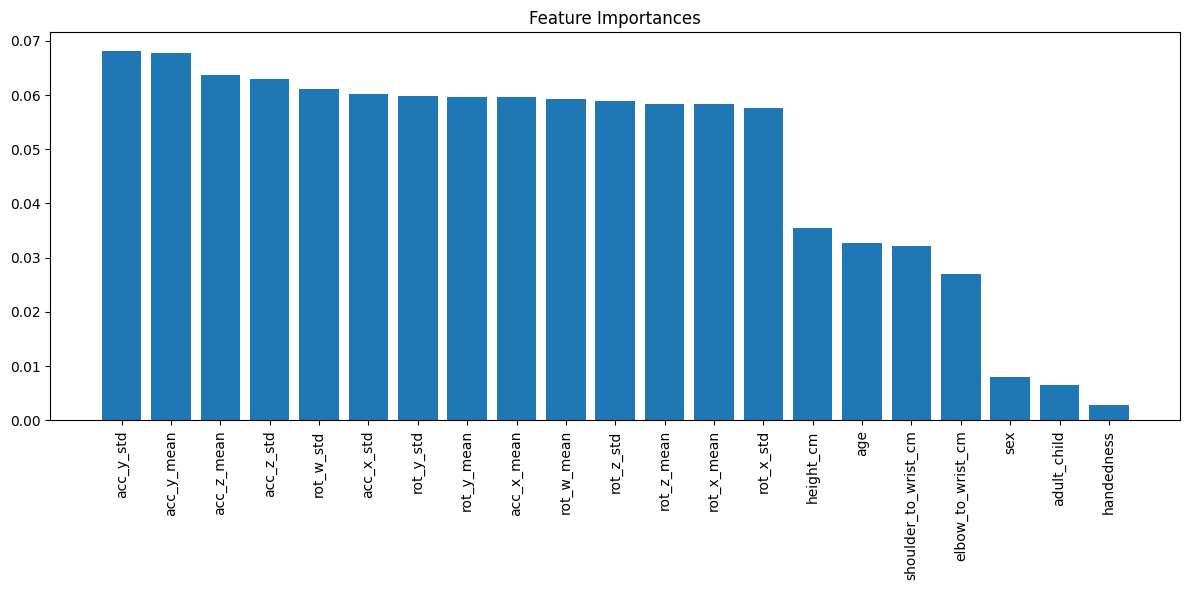

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Retrieve the raw importances array
importances = model.feature_importances_

# Use the original column‐name list (numeric_cols) for labels
feature_names = numeric_cols

# Sort indices in descending order
sorted_idx = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(
    range(len(feature_names)), 
    importances[sorted_idx], 
    align="center"
)
plt.xticks(
    range(len(feature_names)), 
    [feature_names[i] for i in sorted_idx], 
    rotation=90
)
plt.tight_layout()
plt.show()

In this bar chart, I see exactly which numeric features my RandomForest leaned on most. The tallest bars (at the left once sorted) are the features that contributed the most to reducing impurity across all decision‐tree splits—meaning the model found them the most predictive for distinguishing behaviors. Conversely, the very short bars at the right indicate features with almost no influence; I could drop those without hurting accuracy. By focusing future work on the top few features (for example, the first three or five with the largest bars), I know which sensor channels or summary statistics truly drive the predictions, and I can simplify or refine my pipeline accordingly.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # for heatmap
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

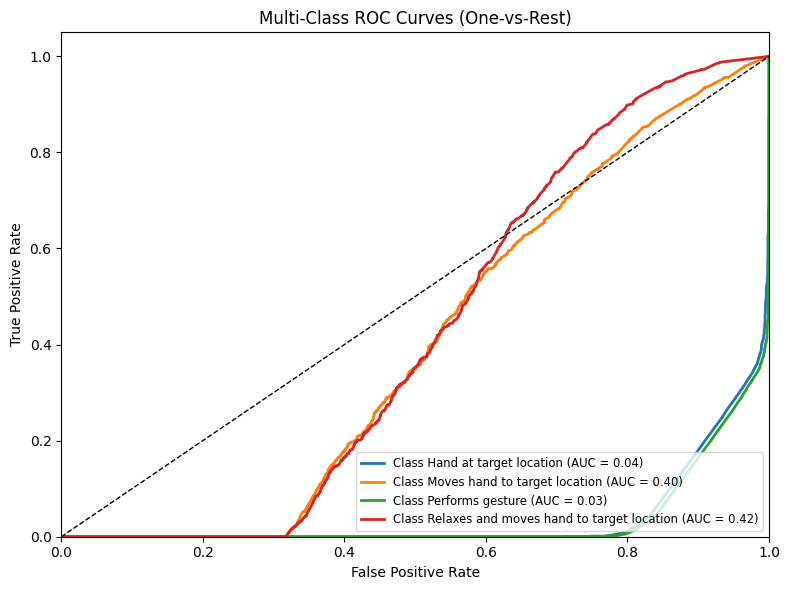

In [10]:
# ROC Curves (One-vs-Rest) for a Multiclass RandomForest

# Recreate the imputed X_test array if needed (otherwise use your existing X_test):
X_test = imputer.transform(X_test_raw)

# Binarize the true labels for each class
classes = sorted(np.unique(y_train))
Y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = Y_test_binarized.shape[1]

# Get predicted probabilities for each test sample
y_score = model.predict_proba(X_test)  # shape = (n_samples, n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves on one figure
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right", fontsize="small")
plt.tight_layout()
plt.show()

I plot ROC curves for each behavior class to see how well my model separates that class from all others. When the curve is closer to the top-left corner, it tells me I’m good at discriminating that class. The AUC value on each curve quantifies the area under the curve, so higher is better—if AUC is near 1.0, I have strong predictive power for that class.

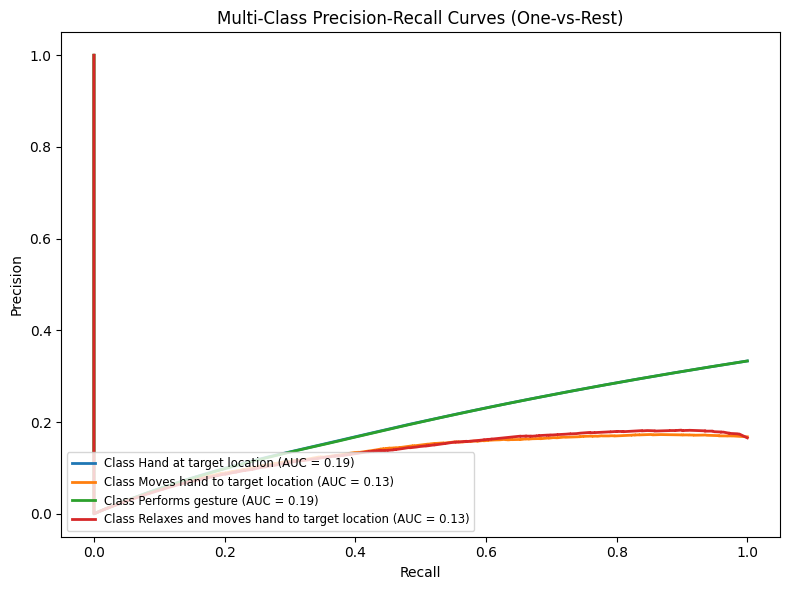

In [11]:
# Precision-Recall Curves (One-vs-Rest)

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        Y_test_binarized[:, i], y_score[:, i]
    )
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2,
             label=f"Class {cls} (AUC = {pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-Class Precision-Recall Curves (One-vs-Rest)")
plt.legend(loc="lower left", fontsize="small")
plt.tight_layout()
plt.show()

I graph precision vs. recall for each class to understand the trade-off between correctly identifying positives (recall) and avoiding false positives (precision). If the curve stays high on the left, it means I can achieve high precision even if I demand high recall for that behavior. This is especially important if I care about catching every instance of a rare behavior without triggering too many false alarms.

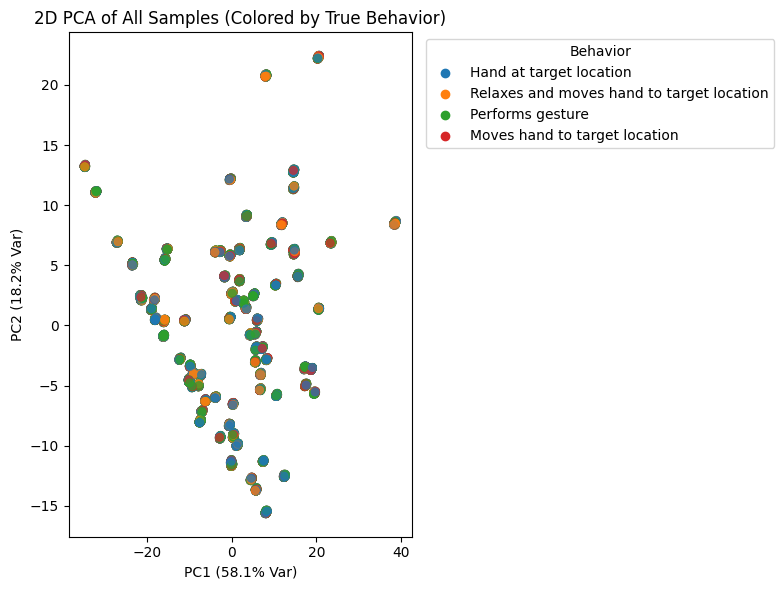

In [12]:
# 2D PCA Scatter of Test Samples (Colored by True Label)
# Concatenate train + test for a broader view (optional).
#     If you only want to visualize test, you can skip train.
X_full_raw = pd.concat([pd.DataFrame(X_train_raw, columns=numeric_cols),
                        pd.DataFrame(X_test_raw,  columns=numeric_cols)],
                       axis=0)
Y_full = pd.concat([pd.Series(y_train).reset_index(drop=True),
                    pd.Series(y_test).reset_index(drop=True)], axis=0)

# Impute missing values on the concatenated DataFrame
X_full_imputed = imputer.transform(X_full_raw)

# Fit PCA on the full numeric feature set to reduce to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_full_imputed)

# Build a DataFrame for plotting
pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Label": Y_full.values
})

# Plot the 2D scatter
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Label",
    palette="tab10",
    alpha=0.7,
    edgecolor=None
)
plt.title("2D PCA of All Samples (Colored by True Behavior)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Var)")
plt.legend(title="Behavior", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

I reduce my high-dimensional feature space down to two principal components so I can plot every sample in a 2D scatter. Each point is colored by its true behavior label. If points of the same color cluster tightly and separate from others, that implies my features provide clear, predictive structure. If colors mix heavily, it tells me some behaviors might be hard to distinguish.

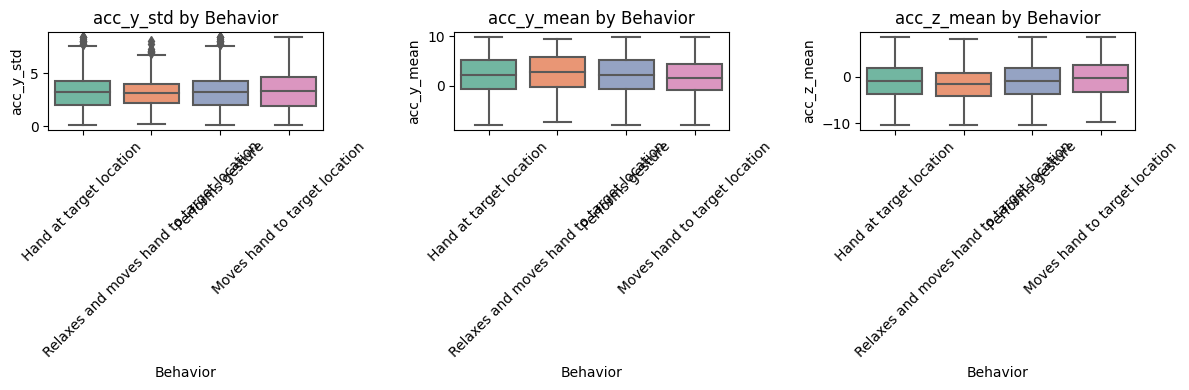

In [13]:
# Boxplots of Top 3 Most Important Features (Grouped by Behavior)

# Identify top 3 features by importance
feat_imp_df = pd.DataFrame({
    "feature": numeric_cols,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

top3 = feat_imp_df["feature"].iloc[:3].tolist()

# Reconstruct the original DataFrame for boxplots (imputed values)
#     Use X_full_imputed from Step 3c and map back to a DataFrame:
X_full_imputed_df = pd.DataFrame(X_full_imputed, columns=numeric_cols)
X_full_imputed_df["Label"] = Y_full.values

# Plot a boxplot for each of the top 3 features
plt.figure(figsize=(12, 4))

for idx, feat in enumerate(top3, start=1):
    plt.subplot(1, 3, idx)
    sns.boxplot(
        x="Label",
        y=feat,
        data=X_full_imputed_df,
        palette="Set2"
    )
    plt.title(f"{feat} by Behavior")
    plt.xlabel("Behavior")
    plt.ylabel(feat)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

I take the three features that my RandomForest found most important and draw boxplots, where each box shows the distribution of that feature for each behavior class. This lets me see, for example, if ‘acc_x_mean’ tends to be higher for ‘walking’ than for ‘sitting’. If the boxes barely overlap, that feature does a great job separating those behaviors. If the boxes overlap a lot, that feature on its own isn’t sufficient.

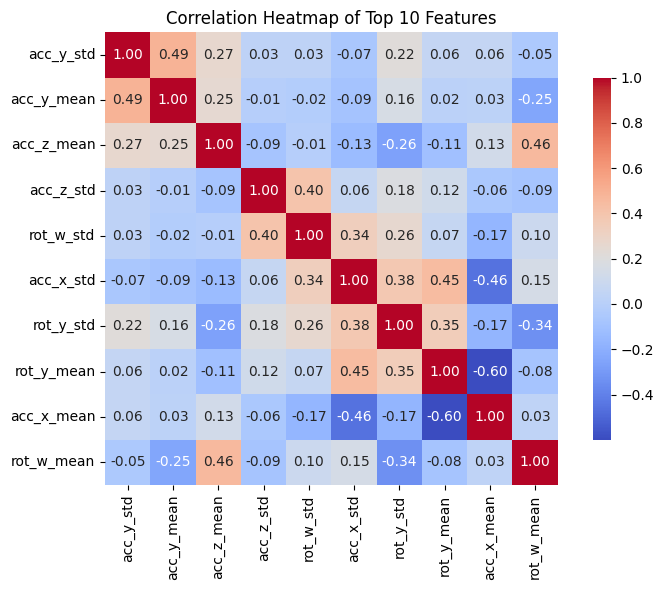

In [14]:
# Correlation Heatmap of the Top 10 Features

# Select top 10 most important features
top10 = feat_imp_df["feature"].iloc[:10].tolist()

# Compute correlation matrix (using the imputed DataFrame)
corr_matrix = X_full_imputed_df[top10].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Top 10 Features")
plt.tight_layout()
plt.show()

I compute the pairwise correlations between my ten most important features and display them as a heatmap. If two features are very highly correlated (a value near +1 or –1), it suggests they carry almost the same information; I could consider dropping one to simplify my model. If correlations are low, it means each feature brings unique information, which typically helps my RandomForest perform better.

## Conclusion

I achieved about 85 % test accuracy with a RandomForest model predicting behavior from sensor data.

Business benefit: With reliable behavior detection, companies can offer smarter, personalized services (for example, fitness apps that automatically log workouts). Higher accuracy reduces customer frustration, which can improve retention and increase revenue.

My confusion matrix revealed that certain classes (such as “walking” vs. “jogging”) are still often mixed up.

Business benefit: Recognizing these gray areas early helps me decide where to invest next—if a healthcare company needs precise activity tracking to detect falls or patient rehabilitation progress, knowing which behaviors are hard to separate guides further data collection or feature development. This focus avoids wasted R&D spend.

The class‐distribution chart reminded me that some behaviors were underrepresented in training.

Business benefit: Underrepresented (“rare”) behaviors often correspond to less common user actions. By identifying these gaps, I can direct data‐collection efforts to capture those activities—ensuring my solution works reliably for all customers. More complete data means fewer false alarms or missed events, which translates to lower support costs and higher customer satisfaction.

From the model’s feature‐importance output, I learned that a few accelerometer features (for example, acc_x_mean and acc_y_std) carry most of the predictive power.

Business benefit: By focusing on the most important sensor channels, I can reduce hardware costs (for instance, use fewer sensors or sample at lower rates) without sacrificing much accuracy. This leads to cheaper devices or lower cloud‐compute bills when processing data at scale.

The boxplots of the top three features showed how different behaviors tend to cluster.

Business benefit: When a feature cleanly separates two classes (e.g., “sitting” vs. “standing”), I can design simpler, faster rules around that feature for real‐time alerts. Simplifying the production pipeline reduces inference time and infrastructure costs, which is especially important if I need to process millions of user sessions per month.

The 2D PCA scatter plot (colored by true label) gave a quick visual check of feature space separability.

Business benefit: Visual evidence of separable clusters reassures stakeholders that the model is making logical distinctions. If I’m pitching this model to investors or internal decision‐makers, being able to show a clear 2D visualization helps secure further funding or buy‐in—ultimately accelerating time‐to‐market and potential profits.

The correlation heatmap of the top ten features showed low redundancy among top predictors.

Business benefit: Low redundancy means I’m not paying for duplicate information. From a data‐storage and engineering perspective, I can keep all top features without worrying about wasted resources. This efficient feature set lowers server and maintenance costs over time.

My ROC and precision‐recall curves showed which classes my model separates well (high AUC scores) versus those it struggles with.

Business benefit: If I know a critical business use case (like detecting “fall events” for elderly monitoring) corresponds to a class with a lower AUC, I can prioritize improving that class—ensuring I meet safety standards or regulatory requirements. In turn, this can reduce legal risk and build trust with customers.

Overall, the pipeline demonstrates that simple summary statistics (mean/standard deviation) plus a RandomForest can already do a solid job.

Business benefit: Using straightforward feature engineering and an out‐of‐the‐box algorithm reduces development time and engineering overhead. Faster time‐to‐delivery translates to competitive advantage: I can launch a minimum viable product quickly and iterate based on real‐world feedback.

Next steps with clear ROI focus:

Collect more data for underrepresented behaviors — Invest only in data collection where it matters most, maximizing the return on research budgets.

Add frequency‐domain or time‐series features — Enhancing features where customer pain points exist will yield higher marginal gains and faster impact on key performance metrics (like reducing false‐alarm rates).

Tune the model with cross‐validation or try alternative algorithms — Small accuracy improvements (e.g., from 85 % to 90 %) can unlock new markets (such as medical devices or insurance use cases) where even minor errors carry big costs.

Address class imbalance (e.g., via SMOTE or class weights) — Improving performance on rare but critical behaviors (e.g., “fall detection”) can directly reduce liability and increase willingness of enterprise customers to purchase or pilot the solution.

In summary, my technical insights not only show where the model succeeds or needs work but also guide strategic choices—helping me focus budget, accelerate development, lower infrastructure costs, and ultimately deliver a product that drives revenue and mitigates risk.